In [1]:
import os, sys, time, resource, re, gc, shutil
from multiprocess import Pool
from functools import partial
from tabulate import tabulate
from urllib.parse import urlparse, parse_qsl

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mongoengine.queryset.visitor import Q
import django
from django.db.models import Count
sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *
from utils.text import *
from utils.plotting import *
from sklearn.feature_extraction.text import *
from sklearn.decomposition import NMF
from scipy.sparse import coo_matrix, find
from django.db.models import Q, F, Sum, Count, FloatField, Case, When

from run_id import run_id
run_id = 662
stat = RunStats.objects.get(pk=run_id)
q = stat.query
print(q.title)

from shapely.geometry import Polygon

from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


wos_all_updated


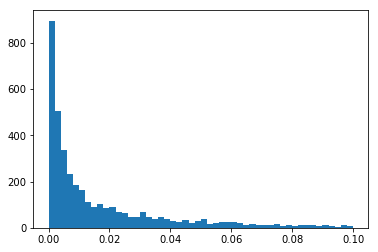

4524

In [2]:
tts = TopicDTopic.objects.filter(dynamictopic__run_id=run_id)


scores = list(tts.values_list('score',flat=True))

plt.hist([s for s in scores if s < 0.1],bins=50)

plt.show()

tts.count()

db_matrix = DocTopic.objects.filter(
    run_id=stat.parent_run_id,
    score__gt=stat.dthreshold,
    topic__topicdtopic__dynamictopic__run_id=run_id,
    topic__topicdtopic__score__gt=stat.dthreshold
).values('doc_id','topic__topicdtopic__dynamictopic').annotate(
    ddt_score = models.Sum(F('score')*F('topic__topicdtopic__score'))
).filter(ddt_score__gt=0.001)

vs = list(db_matrix.values('ddt_score','doc_id','topic__topicdtopic__dynamictopic__id'))



len(vs)

c_ind = np.array(set(list(db_matrix.values_list(
    'doc_id',flat=True
))))
r_ind = np.array(set(list(db_matrix.values_list(
    'topic__topicdtopic__dynamictopic',flat=True
))))

d = [x['ddt_score'] for x in vs]
c = [int(np.where(c_ind==x['doc_id'])[0]) for x in vs]
r = [int(np.where(r_ind==x['topic__topicdtopic__dynamictopic'])[0]) for x in vs]

m = csr_matrix((d,(r,c)),shape=(len(r_ind),len(c_ind)))

print(m.shape)

In [3]:
column = 'term_id'

if column=='doc_id':
    db_matrix = DocTopic.objects.filter(run_id=run_id,score__gt=0.01)
else:
    db_matrix = DynamicTopicTerm.objects.filter(run_id=run_id,score__gt=0.01)


from scipy.sparse import *

vs = list(db_matrix.values('score',column,'topic_id'))

c_ind = np.array(db_matrix.values_list(column,flat=True).order_by(column).distinct())
r_ind = np.array(db_matrix.values_list('topic_id',flat=True).order_by('topic_id').distinct())

d = [x['score'] for x in vs]


c = [int(np.where(c_ind==x[column])[0]) for x in vs]
r = [int(np.where(r_ind==x['topic_id'])[0]) for x in vs]

m = csr_matrix((d,(r,c)),shape=(len(r_ind),len(c_ind)))

print(db_matrix.count())

56208


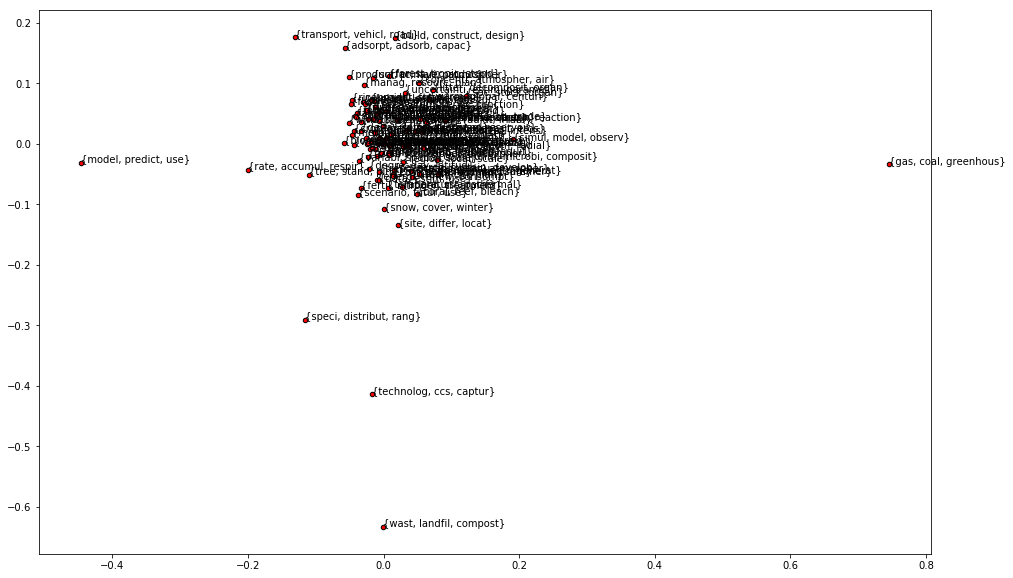

In [4]:
kpca = KernelPCA(kernel="rbf", fit_inverse_transform=True, gamma=10, n_components=2)
X_kpca = kpca.fit_transform(m.toarray())
plt.rcParams["figure.figsize"] = [16,10]

plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c="red",
            s=20, edgecolor='k')


for i,t in enumerate(DynamicTopic.objects.filter(id__in=r_ind)):
    plt.text(X_kpca[i,0],X_kpca[i,1],t.title)

plt.show()

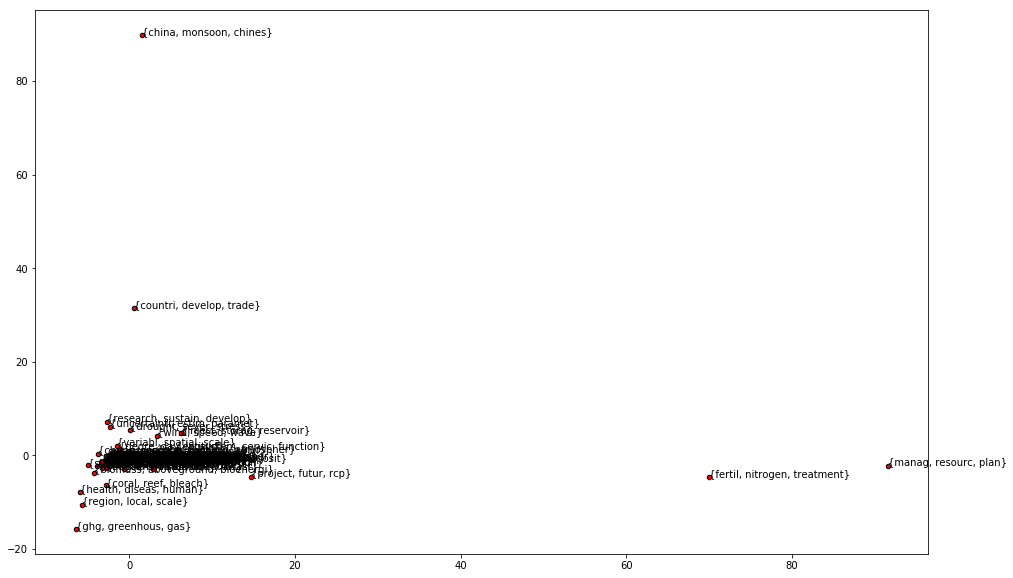

In [5]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(m.toarray())


plt.rcParams["figure.figsize"] = [16,10]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c="red",
            s=20, edgecolor='k')


for i,t in enumerate(DynamicTopic.objects.filter(id__in=r_ind)):
    plt.text(X_pca[i,0],X_pca[i,1],t.title)

plt.show()

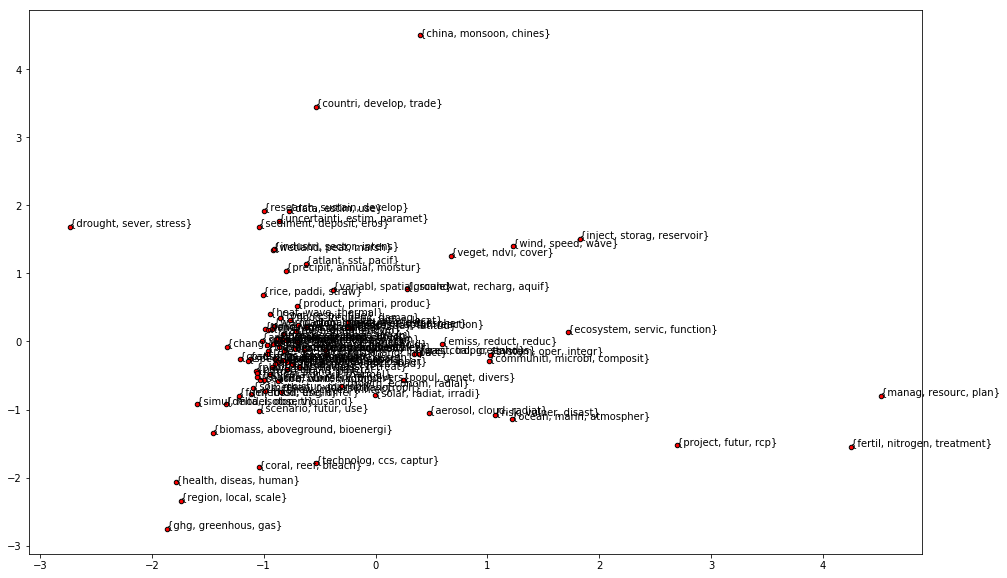

In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(m.toarray())

for r,t in enumerate(X_pca):
    for c,v in enumerate(t):
        if v > 0:
            X_pca[r,c] = np.log(v)
        elif v < 0:
            X_pca[r,c] = np.log(abs(v)) * -1

plt.rcParams["figure.figsize"] = [16,10]

plt.scatter(X_pca[:, 0], X_pca[:, 1], c="red",
            s=20, edgecolor='k')


for i,t in enumerate(DynamicTopic.objects.filter(id__in=r_ind)):
    plt.text(X_pca[i,0],X_pca[i,1],t.title)

plt.show()

/usr/local/lib/python3.4/dist-packages/scipy/spatial/_plotutils.py:17: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  was_held = ax.ishold()
/usr/local/lib/python3.4/dist-packages/scipy/spatial/_plotutils.py:19: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(True)
/usr/local/lib/python3.4/dist-packages/scipy/spatial/_plotutils.py:22: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(was_held)


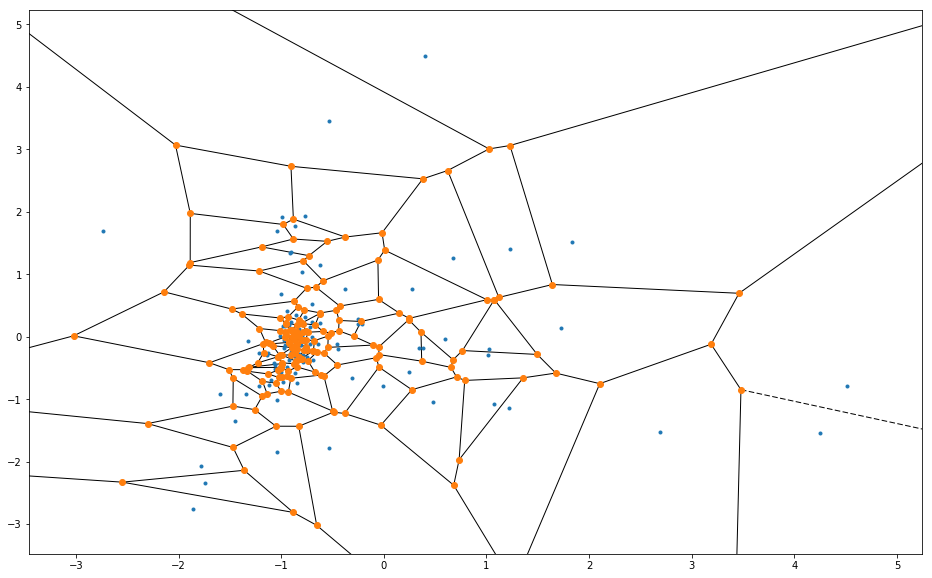

In [7]:
points = X_pca
from scipy.spatial import Voronoi, voronoi_plot_2d
vor = Voronoi(points)
voronoi_plot_2d(vor)
plt.show()


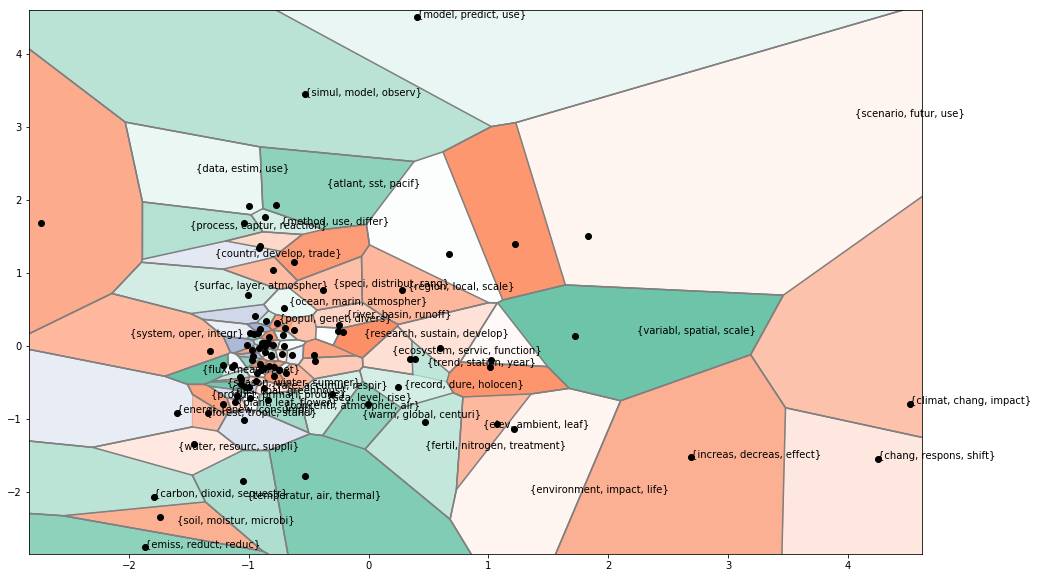

In [8]:
plt.rcParams["figure.figsize"] = [16,10]

regions, vertices = voronoi_finite_polygons_2d(vor)

topics = DynamicTopic.objects.filter(id__in=r_ind).order_by('id')

mscore = topics.order_by('-score').first().score

fig, ax = plt.subplots()

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

for i, region in enumerate(regions):
    polygon = vertices[region]
    p = Polygon(polygon).centroid
    
    
    plt.fill(*zip(*polygon), color=colors[topics[i].primary_wg], alpha=topics[i].score*5/mscore)
    plt.plot(*zip(*polygon),color="grey")
    ti = topics[i].title
    if topics[i].share > 0.01:
        if abs(p.x) > vor.max_bound[0] + 0.1 or \
            p.x < vor.min_bound[0] or \
            abs(p.y) > vor.max_bound[1] + 0.1 :
            #continue
            plt.text(points[i,0],points[i,1],ti)
        else:
            plt.text(p.x,p.y,ti)
plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('../plots/pca_map.png',bbox_inches='tight')

plt.show()


In [9]:
vor.max_bound[0]

4.5168881145580935

In [10]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)

poly3d = []

verts = []

zs = 5

def norm(x,min_x,max_x):
    if x < min_x:
        return 0
    elif x > max_x:
        return 1
    else:
        r = max_x-min_x
    return (x-min_x)/r


x = []
y = []
z = []

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

for i,region in enumerate(regions):
    x = []
    y = []
    z = []
    polygon = vertices[region]
    
    s = topics[i].share*100

    for p in polygon:
        x.append(norm(p[0],vor.min_bound[0],vor.max_bound[0]))
        y.append(norm(p[1],vor.min_bound[1],vor.max_bound[1]))

        #poly3d.append((x[0],x[1],i))
    x.append(x[0])
    y.append(y[0])
    z = [0.1]*len(y)
    #poly3d = np.array(poly3d)
    Y = np.array([y]*zs)
    X = np.array([x]*zs)
    
    Z = np.array([z]*zs)
    
    for j, z in enumerate(Z):
        max_share = norm(np.log(s+1),0,2)
        Z[j] = max_share*(1/zs*j)

    color=colors[topics[i].primary_wg]
    ax.plot_surface(X,Y,Z,rstride=1, cstride=1,alpha=1,color=color)
    
    verts = [list(zip(x,y,Z[-1]))]
    tri = Poly3DCollection(verts)
    tri.set_color(color)
    ax.add_collection3d(tri)   
    
    #plt.show()
    #break
    continue

    #print(z)



    
    zs = 5

    #z = [0] * len(x)
    verts = []
    verts.append(list(zip(x, y,z)))
    


    p3s = Poly3DCollection(verts)
    p3s.set_color(color)
    p3s.set_edgecolor('k')
    
    p3s.set_alpha(0.1)
    ax.add_collection3d(p3s)
      
    
def update(i):
    ax.view_init(60, i)

ani= matplotlib.animation.FuncAnimation(
    plt.gcf(), 
    update, 
    frames=360,
    interval=5, 
    repeat=False
)
#plt.show()


NameError: name 'matplotlib' is not defined

In [ ]:
import matplotlib.animation

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# load some test data for demonstration and plot a wireframe
X, Y, Z = axes3d.get_test_data(0.1)
ax.plot_wireframe(X, Y, Z, rstride=5, cstride=5)

def update(i):
    ax.view_init(30, i)

ani= matplotlib.animation.FuncAnimation(
    plt.gcf(), 
    update, 
    frames=100,
    interval=100, 
    repeat=False
)

# rotate the axes and update
#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import time
import random
%matplotlib notebook

ysample = random.sample(range(-50, 50), 100)

xdata = []
ydata = []

axes = plt.gca()
axes.set_xlim(0, 100)
axes.set_ylim(-50, +50)
line, = axes.plot(xdata, ydata, 'r-')

def update(i):
    xdata.append(i)
    ydata.append(ysample[i])
    line.set_xdata(xdata)
    line.set_ydata(ydata)

ani= matplotlib.animation.FuncAnimation(plt.gcf(), update, frames=100,
                                       interval=100, repeat=False)

plt.show()

In [ ]:
plt.fill(polygon)

plt.show()

print(vor.min_bound)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)


x = [0,1,1,0]
y = [0,0,1,1]
z = [0,1,0,1]

x = [0,1,1,0,0]
y = [0,0,1,1,0]
z = [0.1,0.1,0.1,0.1,0.5]#,0.5]
print(x)
print(z)
verts = [list(zip(x, y,z))]
print(verts)
#poly3d = [list(poly3d)]
#print(poly3d)
#ax.add_collection3d(Poly3DCollection(verts))
Z = np.array([z]*len(z))
print(Z.shape)
ax.contour(x,y,Z)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)

zs = 5

x = [0.0,1.0,0.0,0.0]
y = [0,1,1,0]
z = [0.1]*4
Y = np.array([y]*zs)


print(x)

X = np.array([x]*zs)


print(z)
verts = [list(zip(x, y,z))]
#print(verts)
#poly3d = [list(poly3d)]
#print(poly3d)
#ax.add_collection3d(Poly3DCollection(verts))
Z = np.array([z]*zs)
for i, z in enumerate(Z):
    print(i)
    Z[i] = z*i

print(Z)

print(x)

#ax.contourf(x,y,Z,cmap=cm.coolwarm)
ax.plot_surface(X,Y,Z,rstride=1, cstride=1,alpha=1)


verts = [list(zip(x,y,Z[-1]))]
tri = Poly3DCollection(verts)
ax.add_collection3d(tri)

plt.show()

In [ ]:
from mpl_toolkits.mplot3d import axes3d
X, Y, Z = axes3d.get_test_data(0.5)

X

print("{} {} {}".format(X.shape,Y.shape, Z.shape))


import matplotlib.pyplot as plt
from matplotlib import cm

fig = plt.figure()
ax = fig.gca(projection='3d')
#X, Y, Z = axes3d.get_test_data(0.05)
ax.plot_surface(X, Y, Z, rstride=8, cstride=8, alpha=0.3)
cset = ax.contour(X, Y, Z, zdir='z', offset=-100, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='x', offset=-40, cmap=cm.coolwarm)
cset = ax.contour(X, Y, Z, zdir='y', offset=40, cmap=cm.coolwarm)

ax.set_xlabel('X')
ax.set_xlim(-40, 40)
ax.set_ylabel('Y')
ax.set_ylim(-40, 40)
ax.set_zlabel('Z')
ax.set_zlim(-100, 100)

plt.show()

In [ ]:
print(X)

print(Z)

In [ ]:
scores = topics.values('score') 
scores

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np


fig = plt.figure()
ax = fig.gca(projection='3d')

# Make data.
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [ ]:

fig = plt.figure()
ax = fig.gca(projection='3d')

x = [0.0,1.0,0.0,0.0]
y = [0,1,1,0]
z = [0.1]*len(x)

x_long = []
y_long = []

steps = 5

for i in range(len(x)-1):
    for step in range(steps):
        m = 1/steps*step
        x_long.append(x[i]+(x[i+1]-x[i])*m)
        
for i in range(len(y)-1):  
    for step in range(steps):
        m = 1/steps*step
        y_long.append(y[i]+(y[i+1]-y[i])*m)
    
        
print(x_long)

X,Y = np.meshgrid(x_long,y_long)

R = np.sqrt(X**2 + Y**2)
Z = np.sin(R)

p = 1
clen = len(Z)
for i, row in enumerate(Z):
    rlen = len(row)
    for j, c in enumerate(row):
        if j < rlen/2:
            jm = p*j
        else:
            jm = p*(rlen-j)
        if i < clen/2:
            im = p*i
        else:
            im = p*(clen-i)
        Z[i,j] = im*jm

print(Z)

#print(X)

#print(Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, Z, linewidth=0, antialiased=False)


plt.show()

In [ ]:
np.arange(1,0,0.01)

In [ ]:
import matplotlib.animation

from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
%matplotlib notebook


fig = plt.figure()
#ax = Axes3D(fig)
ax = fig.gca(projection='3d')


def norm(x,min_x,max_x):
    if x < min_x:
        return 0
    elif x > max_x:
        return 1
    else:
        r = max_x-min_x
    return (x-min_x)/r


colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

for ti,region in enumerate(regions):
    x = []
    y = []
    z = []
    x_long = []
    y_long = []
    polygon = vertices[region]
    
    s = topics[ti].share*100

    for p in polygon:
        x.append(norm(p[0],vor.min_bound[0],vor.max_bound[0]))
        y.append(norm(p[1],vor.min_bound[1],vor.max_bound[1]))

        #poly3d.append((x[0],x[1],i))
    x.append(x[0])
    y.append(y[0])
    
    
    for i in range(len(x)-1):
        for j in np.arange(x[i],x[i+1],0.001):
            x_long.append(j)

    for i in range(len(y)-1):
        for j in np.arange(y[i],y[i+1],0.001):
            y_long.append(j)


    X,Y = np.meshgrid(x_long,y_long)
    
    
    R = np.sqrt(X**2 + Y**2)
    Z = np.sin(R)

    p = s
    clen = len(Z)
    for i, row in enumerate(Z):
        rlen = len(row)
        for j, c in enumerate(row):
            if j < rlen/2:
                jm = p*j
            else:
                jm = p*(rlen-j)
            if i < clen/2:
                im = p*i
            else:
                im = p*(clen-i)
            Z[i,j] = im*jm
    
    surf = ax.plot_surface(
        X, Y, Z,
        linewidth=0, 
        antialiased=True,
        color=colors[topics[ti].primary_wg],
        alpha=0.2
    )
    
    if ti > 5:
        break

def update(i):
    ax.view_init(60, i)

ani= matplotlib.animation.FuncAnimation(
    plt.gcf(), 
    update, 
    frames=360,
    interval=5, 
    repeat=False
)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation
import time
import random
%matplotlib notebook

ysample = random.sample(range(-50, 50), 100)

xdata = []
ydata = []

axes = plt.gca()
axes.set_xlim(0, 100)
axes.set_ylim(-50, +50)
line, = axes.plot(xdata, ydata, 'r-')

def update(i):
    xdata.append(i)
    ydata.append(ysample[i])
    line.set_xdata(xdata)
    line.set_ydata(ydata)

ani= matplotlib.animation.FuncAnimation(plt.gcf(), update, frames=100,
                                       interval=100, repeat=False)

plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [10,16]

regions, vertices = voronoi_finite_polygons_2d(vor)

topics = DynamicTopic.objects.filter(id__in=r_ind).order_by('id')

mscore = topics.order_by('-score').first().score

fig, ax = plt.subplots()

colors = {1: "#66c2a5", 2: "#fc8d62" , 3: "#8da0cb"}

for i, region in enumerate(regions):
    polygon = vertices[region]
    p = Polygon(polygon).centroid
    plt.fill(*zip(*polygon), color=colors[topics[i].primary_wg], alpha=topics[i].score*5/mscore)
    plt.plot(*zip(*polygon),color="grey")
    ti = topics[i].title
    if topics[i].share > 0.01:
        if abs(p.x) > vor.max_bound[0] + 0.1 or \
            p.x < vor.min_bound[0] or \
            abs(p.y) > vor.max_bound[1] + 0.1 :
            #continue
            plt.text(points[i,0],points[i,1],ti)
        else:
            plt.text(p.x,p.y,ti)
    if abs(p.x) > vor.max_bound[0] + 0.1 or abs(p.y) > vor.max_bound[1] + 0.1 :
        plt.text(points[i,0],points[i,1],ti)
    else:
        plt.text(p.x,p.y,ti)
plt.plot(points[:,0], points[:,1], 'ko')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

plt.savefig('../plots/pca_map_portrait.png',bbox_inches='tight')

plt.show()

